<a href="https://colab.research.google.com/github/rehabm1996/Task/blob/main/Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [315]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.layers import Dense , SimpleRNN ,GRU , LSTM ,Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
import numpy as np

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 38.6MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [67]:
traffic = pd.read_csv('/content/Traffic Data.csv', parse_dates=['date_time'] , index_col='date_time')

In [68]:
traffic.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [69]:
traffic.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [70]:
traffic['traffic_volume'].unique()

array([1209., 1248., 4602., ..., 6742., 1783., 1132.])

In [71]:
traffic.sample(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-04-19 03:00:00,351.0,281.02,0.00,0.0,90,Clouds,overcast clouds
2017-06-02 09:00:00,4961.0,292.28,0.00,0.0,1,Clear,sky is clear
2018-02-14 03:00:00,348.0,266.22,0.00,0.0,1,Haze,haze
2018-06-07 03:00:00,380.0,289.36,0.00,0.0,1,Clear,sky is clear
2018-02-25 07:00:00,947.0,265.58,0.00,0.0,90,Clouds,overcast clouds
2017-10-17 16:00:00,6700.0,295.61,0.00,0.0,1,Clear,sky is clear
2018-09-14 14:00:00,5231.0,301.26,0.00,0.0,75,Clouds,broken clouds
2018-01-22 18:00:00,1086.0,270.72,0.00,0.0,90,Snow,heavy snow
2018-06-01 05:00:00,2965.0,290.82,0.00,0.0,1,Clear,sky is clear


In [72]:
traffic.sort_index(inplace=True)

In [73]:
traffic.dropna(inplace=True)

In [74]:
traffic.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [75]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19980 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 19980 non-null  float64
 2   rain_1h              19980 non-null  float64
 3   snow_1h              19980 non-null  float64
 4   clouds_all           19980 non-null  int64  
 5   weather_main         19980 non-null  object 
 6   weather_description  19980 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [76]:
traffic.index

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-18 15:00:00',
               '2016-11-18 15:00:00', '2016-11-18 16:00:00',
               '2016-11-18 16:00:00', '2016-11-18 16:00:00',
               '2016-11-18 17:00:00', '2016-11-18 17:00:00',
               '2016-11-18 17:00:00', '2016-11-18 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=19980, freq=None)

In [77]:
traffic.duplicated().sum()

18

In [78]:
traffic.drop_duplicates(inplace=True)

In [79]:
traffic.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description'],
      dtype='object')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

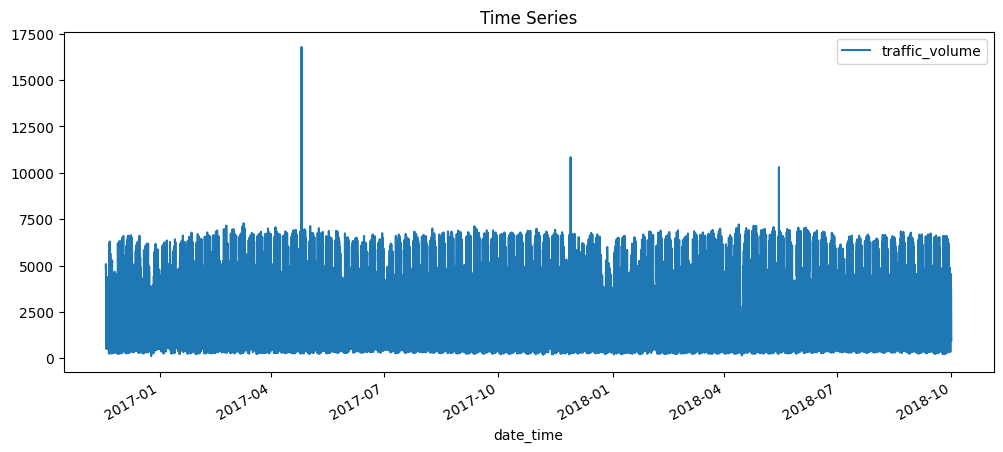

In [267]:
traffic.plot(y=['traffic_volume'] , figsize=(12,5) , title='Time Series')
plt.show()

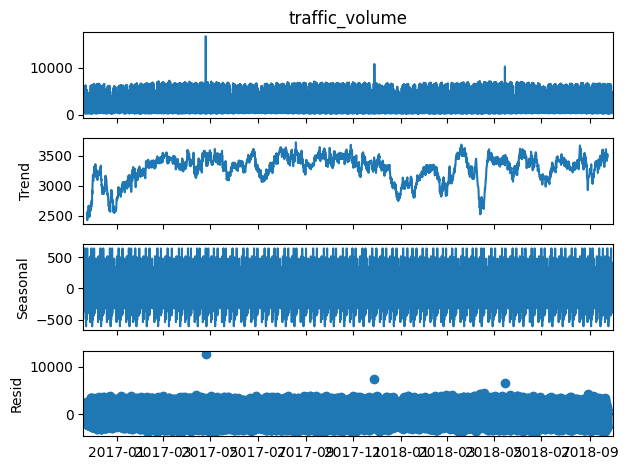

In [274]:
result = seasonal_decompose(traffic['traffic_volume'] , model='additive' , period=365)
result.plot()
plt.show()

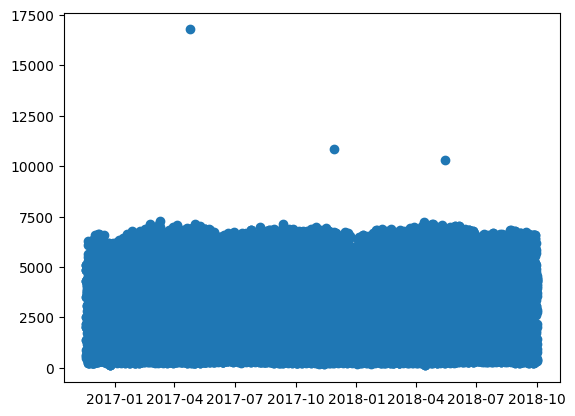

In [272]:
plt.scatter(traffic.index , traffic['traffic_volume'])
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [84]:
traffic.drop(columns=['weather_main' , 'weather_description'] , inplace=True)

In [85]:
traffic.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
date_time,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90


In [99]:
traffic_day = traffic.resample('D').mean()

In [100]:
traffic_day['leg1'] = traffic_day['traffic_volume'].shift(1)
traffic_day['leg2'] = traffic_day['traffic_volume'].shift(2)
traffic_day['leg3'] = traffic_day['traffic_volume'].shift(3)
traffic_day['leg4'] = traffic_day['traffic_volume'].shift(4)
traffic_day['leg5'] = traffic_day['traffic_volume'].shift(5)

In [101]:
traffic_day['avg'] = traffic_day['traffic_volume'].rolling(window=30).mean()

In [102]:
traffic_day['avg'].unique()

array([          nan, 3002.0628708 , 2953.77736355, 2974.63291911,
       3020.98726693, 3030.74560027, 3039.56312163, 3057.30341108,
       3065.01134759, 3047.93140224, 3056.62984278, 3094.50575187,
       3109.1768303 , 3127.90909526, 3137.25476921, 3119.28106232,
       3061.60328454, 3039.37998295, 3052.49919631, 3040.37164075,
       3017.89959774, 2998.42011056, 2975.06058675, 2918.4079633 ,
       2937.58114674, 2976.73428257, 2956.24161138, 2959.028043  ,
       2951.40998745, 2921.89193189, 2902.92001492, 2939.36584825,
       2984.7913555 , 2983.63857772, 2974.23422989, 2967.59168604,
       2948.884876  , 2896.82123379, 2932.97361474, 2994.87956009,
       3036.3603802 , 3057.61871353, 3072.20621353, 3058.70482464,
       3026.00621353, 3033.03436394, 3051.97079556, 3093.24004159,
       3124.99129607, 3139.94996274, 3144.26367242, 3113.97798866,
       3137.0224331 , 3176.72937755, 3188.04010987, 3208.79007233,
       3229.52112072, 3196.69163354, 3150.21696879, 3178.88294

In [104]:
traffic_day.dropna(inplace=True)

In [105]:
traffic_day.head(20)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,leg1,leg2,leg3,leg4,leg5,avg
date_time,,,,,,,,,,,
2016-12-17,1696.725000,258.220500,0.0,0.0,64.500000,2682.871795,3637.625000,3868.333333,3639.291667,3556.973684,3002.062871
2016-12-18,1948.434783,249.040000,0.0,0.0,4.739130,1696.725000,2682.871795,3637.625000,3868.333333,3639.291667,2953.777364
2016-12-19,3336.000000,263.247200,0.0,0.0,19.640000,1948.434783,1696.725000,2682.871795,3637.625000,3868.333333,2974.632919
2016-12-20,3622.130435,272.243478,0.0,0.0,13.304348,3336.000000,1948.434783,1696.725000,2682.871795,3637.625000,3020.987267
2016-12-21,3558.416667,273.563333,0.0,0.0,60.333333,3622.130435,3336.000000,1948.434783,1696.725000,2682.871795,3030.745600
2016-12-22,3538.333333,271.119583,0.0,0.0,4.916667,3558.416667,3622.130435,3336.000000,1948.434783,1696.725000,3039.563122
2016-12-23,3607.071429,273.999524,0.0,0.0,72.690476,3538.333333,3558.416667,3622.130435,3336.000000,1948.434783,3057.303411
2016-12-24,2450.428571,274.166857,0.0,0.0,90.000000,3607.071429,3538.333333,3558.416667,3622.130435,3336.000000,3065.011348
2016-12-25,1498.901639,274.274918,0.0,0.0,90.000000,2450.428571,3607.071429,3538.333333,3558.416667,3622.130435,3047.931402


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [106]:
traffic_day['Difference'] = traffic_day['traffic_volume'].diff()

In [107]:
traffic_day['dayofweek']= traffic_day.index.dayofweek
traffic_day['month']= traffic_day.index.month
traffic_day['dayodyear']= traffic_day.index.dayofyear

In [136]:
traffic_day.dropna(inplace=True)

In [137]:
traffic_day.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,leg1,leg2,leg3,leg4,leg5,avg,Difference,dayofweek,month,dayodyear
date_time,,,,,,,,,,,,,,,
2016-12-18,1948.434783,249.040000,0.0,0.0,4.739130,1696.725000,2682.871795,3637.625000,3868.333333,3639.291667,2953.777364,251.709783,6,12,353
2016-12-19,3336.000000,263.247200,0.0,0.0,19.640000,1948.434783,1696.725000,2682.871795,3637.625000,3868.333333,2974.632919,1387.565217,0,12,354
2016-12-20,3622.130435,272.243478,0.0,0.0,13.304348,3336.000000,1948.434783,1696.725000,2682.871795,3637.625000,3020.987267,286.130435,1,12,355
2016-12-21,3558.416667,273.563333,0.0,0.0,60.333333,3622.130435,3336.000000,1948.434783,1696.725000,2682.871795,3030.745600,-63.713768,2,12,356
2016-12-22,3538.333333,271.119583,0.0,0.0,4.916667,3558.416667,3622.130435,3336.000000,1948.434783,1696.725000,3039.563122,-20.083333,3,12,357


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [195]:
traffic_uni = traffic['traffic_volume']

In [196]:
train , test_val = train_test_split(traffic_uni , test_size=0.3 , random_state=42 , shuffle=False)
test , val = train_test_split(test_val , test_size=0.5 , random_state=42 , shuffle=False)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [197]:
scaler = MinMaxScaler()
train_pre = scaler.fit_transform(train.values.reshape(-1,1))
test_pre = scaler.transform(test.values.reshape(-1,1))
val_pre = scaler.transform(val.values.reshape(-1,1))

In [198]:
window_size=30

train_xy = timeseries_dataset_from_array(train_pre , targets=train_pre[window_size:] , sequence_length=window_size)
test_xy = timeseries_dataset_from_array(test_pre , targets=test_pre[window_size:] , sequence_length=window_size)
val_xy = timeseries_dataset_from_array(val_pre , targets=val_pre[window_size:] , sequence_length=window_size)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [357]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(1 , activation='tanh' , return_sequences=True , input_shape=(30, 1)))
model_rnn.add(SimpleRNN(20 , activation='tanh' , return_sequences=True))
model_rnn.add(SimpleRNN(60 , activation='tanh'))
model_rnn.add(Dense(1 , activation='relu'))

In [358]:
model_rnn.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_67 (SimpleRNN)            │ (None, 30, 1)               │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_68 (SimpleRNN)            │ (None, 30, 20)              │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_69 (SimpleRNN)            │ (None, 60)                  │           4,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,364 (20.95 KB)

 Trainable params: 5,364 (20.95 KB)

 Non-trainable params: 0 (0.00 B)

In [359]:
model_rnn.compile(optimizer='adam' , loss='mse' , metrics=['mae'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [360]:
history_rnn = model_rnn.fit(train_xy , validation_data=val_xy , epochs=10 , batch_size=32)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0206 - mae: 0.1123 - val_loss: 0.0046 - val_mae: 0.0556
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0055 - mae: 0.0578 - val_loss: 0.0023 - val_mae: 0.0345
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0023 - mae: 0.0357 - val_loss: 0.0014 - val_mae: 0.0271
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0016 - mae: 0.0289 - val_loss: 0.0012 - val_mae: 0.0248
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0014 - mae: 0.0264 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0011 - val_mae: 0.0246
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0011 - val_mae: 0.0243
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 0.0010 - val_mae: 0.0237
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [361]:
pred_rnn = model_rnn.predict(test_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [362]:
true_xy = np.concatenate([y for x,y in test_xy] , axis=0)

<Axes: >

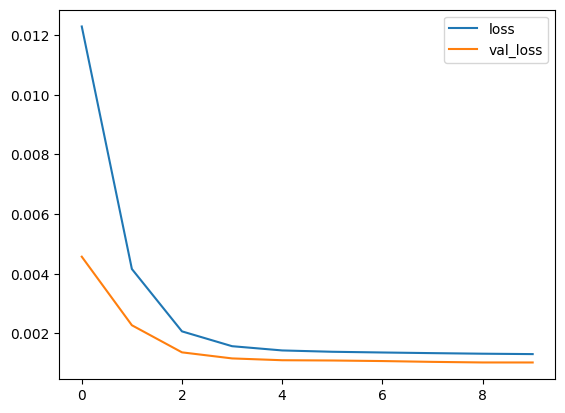

In [363]:
pd.DataFrame(history_rnn.history)[['loss' , 'val_loss']].plot()

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [212]:
true_xy.shape

(2964, 1)

In [213]:
model_rnn.evaluate(test_xy)
model_rnn.evaluate(train_xy)
model_rnn.evaluate(val_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - mae: 0.0283
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - mae: 0.0283
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - mae: 0.0268


[0.001220465055666864, 0.02709479257464409]

In [215]:
print(mean_absolute_error(pred_rnn , true_xy))
print(mean_absolute_percentage_error(pred_rnn , true_xy))
print(mean_squared_error(pred_rnn ,true_xy))

0.028359851093089673
70009875198.51349
0.0015513090920128468


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [325]:
model_lstm = Sequential()
model_lstm.add(LSTM(1 , activation='tanh' , return_sequences=True , input_shape=(30, 1)))
model_lstm.add(LSTM(20 , activation='tanh'))
model_lstm.add(Dense(1 , activation='relu'))

In [326]:
model_lstm.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 30, 1)               │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 20)                  │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

In [327]:
model_lstm.compile(optimizer='adam' , loss='mse' , metrics=['mae'])

In [328]:
history_lstm = model_lstm.fit(train_xy , validation_data=val_xy , epochs=5 , batch_size=32)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0148 - mae: 0.1031 - val_loss: 0.0083 - val_mae: 0.0756
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0082 - mae: 0.0736 - val_loss: 0.0064 - val_mae: 0.0639
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0066 - mae: 0.0643 - val_loss: 0.0054 - val_mae: 0.0587
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0055 - mae: 0.0582 - val_loss: 0.0047 - val_mae: 0.0540
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0047 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0462


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [287]:
pred_lstm = model_lstm.predict(test_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [288]:
model_lstm.evaluate(test_xy)
model_lstm.evaluate(train_xy)
model_lstm.evaluate(val_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - mae: 0.0452
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0030 - mae: 0.0409
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - mae: 0.0384


[0.0028416700661182404, 0.03925754129886627]

In [289]:
print(mean_absolute_error(pred_lstm , true_xy))
print(mean_absolute_percentage_error(pred_lstm , true_xy))
print(mean_squared_error(pred_lstm , true_xy))

0.044044808833212545
0.3443076323289438
0.003648419280207445


<Axes: >

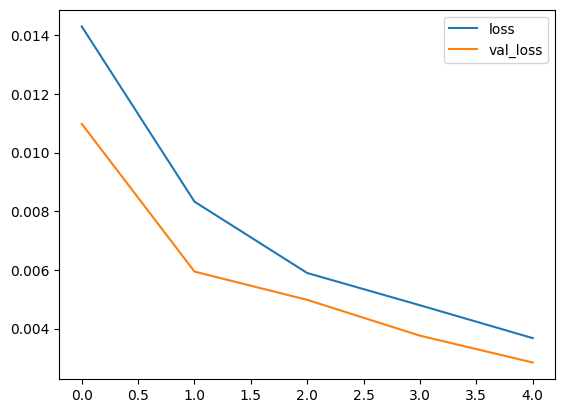

In [290]:
pd.DataFrame(history_lstm.history)[['loss' , 'val_loss']].plot()

In [307]:
model_gru = Sequential()
model_gru.add(GRU(1 , activation='tanh' , return_sequences=True , input_shape=(30, 1)))
model_gru.add(GRU(20 , activation='tanh' , return_sequences=True))
model_gru.add(GRU(40 , activation='tanh' , return_sequences=True))
model_gru.add(GRU(20 , activation='tanh'))
model_gru.add(Dense(1 , activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [308]:
model_gru.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                          │ (None, 30, 1)               │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 30, 20)              │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 30, 40)              │           7,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 20)                  │           3,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,573 (49.11 KB)

 Trainable params: 12,573 (49.11 KB)

 Non-trainable params: 0 (0.00 B)

In [309]:
model_gru.compile(optimizer='adam' , loss='mse' , metrics=['mae'])

In [310]:
history_gru = model_gru.fit(train_xy , validation_data=val_xy , epochs=5 , batch_size=32)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - loss: 0.0151 - mae: 0.1039 - val_loss: 0.0056 - val_mae: 0.0573
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0049 - mae: 0.0543 - val_loss: 0.0032 - val_mae: 0.0421
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.0028 - mae: 0.0399 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0017 - mae: 0.0291 - val_loss: 0.0012 - val_mae: 0.0251
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0012 - val_mae: 0.0243


In [311]:
pred_rgu = model_gru.predict(test_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [312]:
model_rnn.evaluate(test_xy)
model_rnn.evaluate(train_xy)
model_rnn.evaluate(val_xy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024 - mae: 0.0359
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0022 - mae: 0.0347
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - mae: 0.0320


[0.0019967814441770315, 0.033107858151197433]

In [313]:
print(mean_absolute_error(pred_rgu , true_xy))
print(mean_absolute_percentage_error(pred_rgu , true_xy))
print(mean_squared_error(pred_rgu , true_xy))

0.0258248509547507
98633704381.11108
0.0015744411127573959


<Axes: >

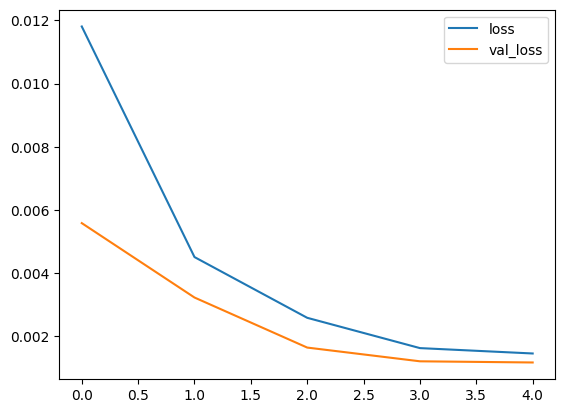

In [314]:
pd.DataFrame(history_gru.history)[['loss' , 'val_loss']].plot()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

**I chose to delete the columns ['weather_main', 'weather_description'] because I found that they exist in detail , I also did not run this column prev_traffic_volume because I ran it before with the name leg1 ,  I faced a problem at the beginning in .resample ('D') because I put M and it was showing traffic_day['avg'] as null but when I modified it the problem was solved and I think that is because of the day or month, and I think it is useful when building new columns Such as month and day,  Because it is a regression we chose the matrix and loss mse and mae , When comparing the three models I found that GRU is the best and the more we increased the layer size it improved unlike LSTM and RNN the more the layer increased it got worse**

**When increasing the size of the epochs and decreasing the layers in the RNN, the model began to improve.**

**I tried used DROPOUT as well but the pattern was getting worse.**
